# Restricted Parking

Idea:

- Build flow graph with road sections as nodes
- Learn flow values from observations
- Compute best parking space allocation from graph structure and flow values

In [1]:
import random
from collections import Counter
import itertools
import math

import networkx as nx
import numpy as np
import pandas as pd
from scipy.special import softmax
from tqdm import trange, tqdm

## Manual minimal setting (v0)

In [ ]:
def draw_network(network):
    nx.draw(network, nx.get_node_attributes(network, 'position'), labels={n: str(n) for n in network.nodes})

In [ ]:
def find_parking_space(network, parking_spaces, car, alpha=1.0):
    utilities = np.array([car.utility(network, parking_space) for parking_space in parking_spaces if nx.has_path(network, car.entry, parking_space.node)])
    probabilities = softmax(-utilities / alpha)

    return np.random.choice(len(probabilities), p=probabilities)

In [ ]:
def update_latencies(network):
    nx.set_edge_attributes(network, {(v, w): attr['latency_fn'](attr['flow']) for v, w, attr in network.edges(data=True)}, 'latency')

def update_flow(network, flow):
    nx.set_edge_attributes(network, flow, 'flow')

    update_latencies(network)

In [ ]:
class Car:
    def __init__(self, entry, exit, target) -> None:
        self.entry = entry
        self.exit = exit
        self.target = target

        self.alpha = 10.0 # Scaling factor for softmax at action selection
        self.beta = 10 # Relative disutility of walking

    def utility(self, network, parking_space):
        return nx.shortest_path_length(network, self.entry, parking_space.node, weight='latency') + self.beta * np.linalg.norm(self.target - parking_space.position)

    def compute_action_probabilities(self, network, parking_spaces):
        utilities = np.array([self.utility(network, parking_space) for parking_space in parking_spaces if nx.has_path(network, self.entry, parking_space.node)])
        
        return softmax(-utilities / self.alpha)

    def find_parking_space(self, network, parking_spaces):
        probabilities = self.compute_action_probabilities(network, parking_spaces)
        
        return np.random.choice(len(probabilities), p=probabilities)
    
    def act(self, network, parking_spaces):
        probabilities = self.compute_action_probabilities(network, parking_spaces)
        parking_space = np.random.choice(len(probabilities), p=probabilities)

        return nx.shortest_path(self.network, self.entry, self.parking_spaces[parking_space].node, weight='latency') + nx.shortest_path(self.network, self.parking_spaces[parking_space].node, self.exit, weight='latency')[1:]

    def __repr__(self) -> str:
        return f'<Car entry={self.entry}, exit={self.exit}, target={self.target}'

class ParkingSpace:
    def __init__(self, node, position) -> None:
        self.node = node
        self.position = position
        self.allowed = True

class ParkingModel:
    def __init__(self, network, parking_spaces, cars) -> None:
        self.network = network
        self.parking_spaces = parking_spaces
        self.cars = cars
    
    def step(self, alpha=1.0):
        routes = [car.act(self.network, self.parking_spaces) for car in self.cars]
        utilization = Counter(sum((tuple(zip(route, route[1:])) for route in routes), start=()))
        flow = {edge: utilization[edge] for edge in self.network.edges}
        update_flow(self.network, flow)

    def report(self):
        return pd.DataFrame({'flow': nx.get_edge_attributes(self.network, 'flow'), 'latency': nx.get_edge_attributes(self.network, 'latency')})


In [ ]:
network = nx.DiGraph([(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)])

node_positions = {
    0: np.array([0, 1]),
    1: np.array([0.5, 1]),
    2: np.array([1, 1]),
    3: np.array([0, 0]),
    4: np.array([0.5, 0]),
    5: np.array([1, 0])
}

nx.set_node_attributes(network, node_positions, 'position')

# Latency is defined in terms of the load, i.e., the number of cars on the road
latency_fns = {
    (0, 1): lambda n: 3 + n / 2,
    (0, 3): lambda n: 2,
    (1, 2): lambda n: 3 + n / 2,
    (2, 5): lambda n: 2,
    (3, 4): lambda n: 3 + n / 2,
    (4, 5): lambda n: 3 + n / 2,
}

nx.set_edge_attributes(network, latency_fns, 'latency_fn')

parking_spaces = [
    ParkingSpace(1, np.array([0.5, 0.8])),
    ParkingSpace(4, np.array([0.5, 0.2]))
]

In [ ]:
draw_network(network)

In [ ]:
# number_of_cars = 100
# cars = [Car(entry, 5, target) for entry, target in zip(np.random.choice([0, 3], size=number_of_cars), np.random.normal(loc=0.5, scale=0.3, size=(number_of_cars, 2)).clip(-1, 1))]

number_of_cars = 10
cars = [Car(0, 5, np.array([0.5, 0.5])) for _ in range(number_of_cars)]

In [ ]:
initial_flow = {
    (0, 1): 0,
    (0, 3): 0,
    (1, 2): 0,
    (2, 5): 0,
    (3, 4): 0,
    (4, 5): 0
}

update_flow(network, initial_flow)

In [ ]:
model = ParkingModel(network, parking_spaces, cars)
alpha = 10

print(model.report())

In [ ]:
model.step(alpha=10)
alpha = (alpha + 1) / 2
print(f'{alpha=}')
model.report()

## Manual minimal setting (v1)

In [2]:
class Car:
    def __init__(self, entry, exit, target, alpha=1.0, beta=2.0) -> None:
        self.entry = entry
        self.exit = exit
        self.target = target

        self.alpha = alpha # Scaling factor for softmax at action selection
        self.beta = beta # Relative disutility of walking

    def utility(self, network, parking_space):
        return -nx.shortest_path_length(network, self.entry, parking_space.node, weight='latency') - self.beta * np.linalg.norm(self.target - parking_space.position)

    def compute_action_probabilities(self, network, parking_spaces):
        utilities = np.array([self.utility(network, parking_space) for parking_space in parking_spaces if nx.has_path(network, self.entry, parking_space.node)])
        
        return softmax(utilities / self.alpha)

    def find_parking_space(self, network, parking_spaces):
        probabilities = self.compute_action_probabilities(network, parking_spaces)
        
        return np.random.choice(len(probabilities), p=probabilities)

    def __repr__(self) -> str:
        return f'<Car {self.entry} -> {self.target} -> {self.exit}'

class ParkingSpace:
    def __init__(self, node, position) -> None:
        self.node = node
        self.position = position
        self.allowed = True

class ParkingModel:
    def __init__(self, network, parking_spaces, cars) -> None:
        self.network = network
        self.parking_spaces = parking_spaces
        self.cars = cars

    @property
    def allowed_parking_spaces(self):
        return [parking_space for parking_space in self.parking_spaces if parking_space.allowed]

In [3]:
def update_latencies(network):
    nx.set_edge_attributes(network, {(v, w): attr['latency_fn'](attr['flow']) for v, w, attr in network.edges(data=True)}, 'latency')

def update_flow(network, flow):
    nx.set_edge_attributes(network, flow, 'flow')

    update_latencies(network)

In [13]:
def run_model(model, number_of_steps, show_tqdm=True):
    x = []
    parking_lot_capacity = Counter(parking_space.node for parking_space in model.allowed_parking_spaces)
    worst_case_utility = -100

    result = []

    for _ in trange(number_of_steps) if show_tqdm else range(number_of_steps):
        chosen_parking_spaces, chosen_routes = [], []
        parking_lot_probabilities = {node: 0 for node in model.network.nodes() if parking_lot_capacity[node] > 0}

        for i, car in enumerate(model.cars):
            parking_space_utilities = [-nx.shortest_path_length(model.network, car.entry, parking_space.node, weight='latency') - car.beta * np.linalg.norm(car.target - parking_space.position) if nx.has_path(network, car.entry, parking_space.node) else -np.inf for parking_space in model.allowed_parking_spaces]
            parking_space_probabilities = softmax(np.array(parking_space_utilities) / car.alpha)

            chosen_parking_space = np.random.choice(len(parking_space_probabilities), p=parking_space_probabilities)
            chosen_parking_spaces.append(chosen_parking_space)

            chosen_route = nx.shortest_path(model.network, car.entry, model.allowed_parking_spaces[chosen_parking_space].node, weight='latency') + nx.shortest_path(model.network, model.allowed_parking_spaces[chosen_parking_space].node, car.exit, weight='latency')[1:]
            chosen_routes.append(chosen_route)

            for parking_space, probability in zip(model.allowed_parking_spaces, parking_space_probabilities):
                parking_lot_probabilities[parking_space.node] += probability

            if i == 0:
                x.append(parking_space_probabilities)

        utilization = Counter(sum((tuple(zip(route, route[1:])) for route in chosen_routes), start=()))
        flow = {edge: utilization[edge] for edge in model.network.edges}
        update_flow(model.network, flow)

        parking_lot_load = Counter(model.allowed_parking_spaces[chosen_parking_space].node for chosen_parking_space in chosen_parking_spaces)
        parking_lot_utilization = {node: parking_lot_load[node] / parking_lot_capacity[node] for node in model.network.nodes() if parking_lot_capacity[node] > 0}

        social_welfare = 0
        for car, chosen_parking_space in zip(cars, chosen_parking_spaces):
            utility = car.utility(network, model.allowed_parking_spaces[chosen_parking_space])
            probability = min(1, 1 / parking_lot_utilization[model.allowed_parking_spaces[chosen_parking_space].node])

            social_welfare += utility * probability + worst_case_utility * (1 - probability)

        result.append({'social_welfare': social_welfare / len(cars), **parking_lot_utilization, **{f'p({node})': parking_lot_probabilities[node] / len(model.cars) for node in parking_lot_probabilities}})

    return pd.DataFrame(result), x

In [37]:
network = nx.DiGraph([(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)])

node_positions = {
    0: np.array([0, 1]),
    1: np.array([0.5, 1]),
    2: np.array([1, 1]),
    3: np.array([0, 0]),
    4: np.array([0.5, 0]),
    5: np.array([1, 0])
}

nx.set_node_attributes(network, node_positions, 'position')

# Latency is defined in terms of the load, i.e., the number of cars on the road
latency_fns = {
    (0, 1): lambda n: 3 + 3 * n,
    (0, 3): lambda n: 0,
    (1, 2): lambda n: 3 + 3 * n,
    (2, 5): lambda n: 0,
    (3, 4): lambda n: 3 + 3 * n,
    (4, 5): lambda n: 3 + 3 * n,
}

nx.set_edge_attributes(network, latency_fns, 'latency_fn')

update_flow(network, {edge: 0 for edge in network.edges})

parking_spaces = [ParkingSpace(1, np.array([0.5, 0.8])) for _ in range(7)] + [ParkingSpace(4, np.array([0.5, 0.2])) for _ in range(10)]

number_of_cars = 10
cars = [Car(0, 5, np.array([0.5, 0.6]), alpha=3) for _ in range(number_of_cars)] # Parking spaces at node 1 are slightly more attractive

### Step by step

In [38]:
model = ParkingModel(network, parking_spaces, cars)

car = cars[0]

utilities = [-nx.shortest_path_length(model.network, car.entry, parking_space.node, weight='latency') - car.beta * np.linalg.norm(car.target - parking_space.position) if nx.has_path(network, car.entry, parking_space.node) else -np.inf for parking_space in model.allowed_parking_spaces]
probabilities = softmax(np.array(utilities) / car.alpha)

pd.DataFrame({'lot': [space.node for space in model.parking_spaces], 'u': utilities, 'p': probabilities})


,lot,u,p
0,1,-3.4,0.063485
1,1,-3.4,0.063485
2,1,-3.4,0.063485
3,1,-3.4,0.063485
4,1,-3.4,0.063485
5,1,-3.4,0.063485
6,1,-3.4,0.063485
7,4,-3.8,0.055560
8,4,-3.8,0.055560
9,4,-3.8,0.055560


### Single run

In [373]:
model = ParkingModel(network, parking_spaces, cars)

result, x = run_model(model, 1000)
result['social_welfare'].mean()

100%|██████████| 1000/1000 [00:02<00:00, 470.90it/s]


-53.26719999999999

<Axes: >

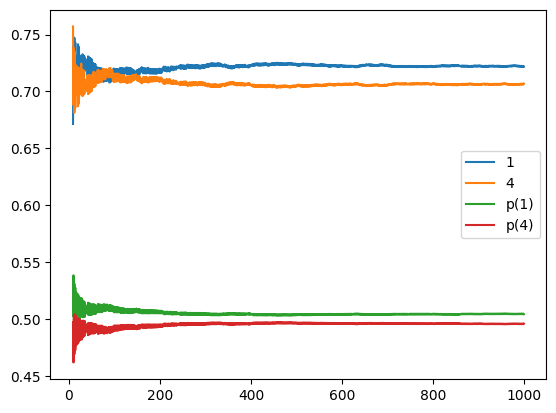

In [329]:
result.drop('social_welfare', axis=1, inplace=False).expanding(10).mean().plot()

In [330]:
result

,social_welfare,1,4,p(1),p(4)
0,-8.76,0.857143,0.571429,0.533284,0.466716
1,-9.48,0.428571,1.000000,0.369740,0.630260
2,-9.32,1.000000,0.428571,0.812550,0.187450
3,-10.34,0.285714,1.142857,0.231475,0.768525
4,-11.16,1.285714,0.142857,0.894101,0.105899
...,...,...,...,...,...
995,-12.66,0.000000,1.428571,0.039166,0.960834
996,-12.38,1.428571,0.000000,0.969724,0.030276
997,-12.66,0.000000,1.428571,0.039166,0.960834
998,-12.38,1.428571,0.000000,0.969724,0.030276


In [335]:
model = ParkingModel(network, parking_spaces, cars)

for i in [3, 4, 5, 6]:
    model.parking_spaces[i].allowed = False

result, x = run_model(model, 1000)
result['social_welfare'].mean()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 594.24it/s]


-11.24634

<Axes: >

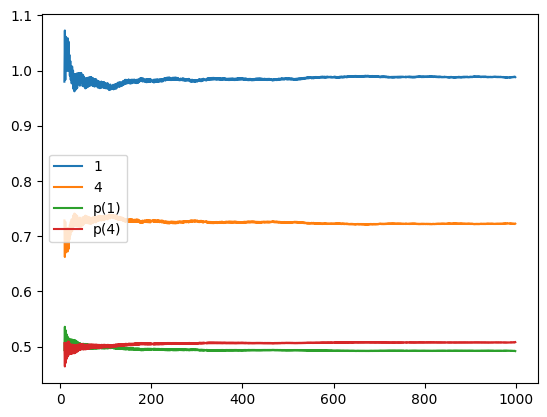

In [332]:
result.drop('social_welfare', axis=1, inplace=False).expanding(10).mean().plot()

### Multiple runs

In [7]:
model = ParkingModel(network, parking_spaces, cars)

parking_spaces_per_node = {node: [parking_space for parking_space in model.parking_spaces if parking_space.node == node] for node in model.network.nodes }
parking_spaces_per_node

number_of_parking_spaces_per_node = {node: len(parking_spaces) for node, parking_spaces in parking_spaces_per_node.items() }
number_of_parking_spaces_per_node

# options = list(itertools.product(*[list(range(n + 1)) for n in number_of_parking_spaces_per_node.values()]))
options = [(0, 10, 0, 0, 0, 10), (0, 9, 0, 0, 0, 10), (0, 8, 0, 0, 0, 10), (0, 7, 0, 0, 0, 10), (0, 6, 0, 0, 0, 10), (0, 1, 0, 0, 0, 1)]

results = []
for number_of_allowed_parking_spaces_per_node in tqdm(options):
    allowed_parking_spaces = sum([parking_spaces[:number_of_allowed_parking_spaces] for (node, parking_spaces), number_of_allowed_parking_spaces in zip(parking_spaces_per_node.items(), number_of_allowed_parking_spaces_per_node)], start=[])

    if len(allowed_parking_spaces) == 0:
        continue

    for parking_space in model.parking_spaces:
        parking_space.allowed = False

    for parking_space in allowed_parking_spaces:
        parking_space.allowed = True

    result, _ = run_model(model, 1000, show_tqdm=False)
    results.append({'number_of_allowed_parking_spaces_per_node': number_of_allowed_parking_spaces_per_node, 'social_welfare': result['social_welfare'].mean(), 'p(1)': result['p(1)'].mean()})

100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


In [8]:
pd.DataFrame(results).sort_values('social_welfare', ascending=False)

,number_of_allowed_parking_spaces_per_node,social_welfare,p(1)
0,"(0, 10, 0, 0, 0, 10)",-73.60,0.5
1,"(0, 9, 0, 0, 0, 10)",-74.93,0.5
2,"(0, 8, 0, 0, 0, 10)",-76.26,0.5
3,"(0, 7, 0, 0, 0, 10)",-77.59,0.5
4,"(0, 6, 0, 0, 0, 10)",-78.92,0.5
5,"(0, 1, 0, 0, 0, 1)",-97.36,0.5


## Sequential decision model

In [207]:
def get_utility(network, parking_spaces, state, car, parking_space, route, minimal_utility=-1000):
    navigation_utility = -sum(network[v][w]['latency'] for v, w in zip(route, route[1:]))
    distance_utility = -np.linalg.norm(car.target - parking_space.position)

    node_utilization = Counter(parking_spaces[parking_space_id].node for parking_space_id, _ in state if parking_space_id is not None)
    parking_probability = min(1.0, len(network.nodes[parking_space.node]['parking_spaces']) / node_utilization[parking_space.node])

    return parking_probability * (navigation_utility + car.beta * distance_utility) + (1 - parking_probability) * minimal_utility

In [208]:
network = nx.DiGraph([(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)])

node_positions = {
    0: np.array([0, 1]),
    1: np.array([0.5, 1]),
    2: np.array([1, 1]),
    3: np.array([0, 0]),
    4: np.array([0.5, 0]),
    5: np.array([1, 0])
}

nx.set_node_attributes(network, node_positions, 'position')

# Latency is defined in terms of the load, i.e., the number of cars on the road
latency_fns = {
    (0, 1): lambda n: 3 + 3 * n,
    (0, 3): lambda n: 0,
    (1, 2): lambda n: 3 + 3 * n,
    (2, 5): lambda n: 0,
    (3, 4): lambda n: 3 + 3 * n,
    (4, 5): lambda n: 3 + 3 * n,
}

nx.set_edge_attributes(network, latency_fns, 'latency_fn')

update_flow(network, {edge: 0 for edge in network.edges})

parking_spaces = [ParkingSpace(1, np.array([0.5, 0.8])) for _ in range(10)] + [ParkingSpace(4, np.array([0.5, 0.2])) for _ in range(10)]

nx.set_node_attributes(network, {node: [parking_space for parking_space in parking_spaces if parking_space.node == node] for node in network.nodes}, 'parking_spaces')

number_of_cars = 10
cars = [Car(0, 5, np.array([0.5, 0.6]), alpha=0.1) for _ in range(number_of_cars)] # Parking spaces at node 1 are slightly more attractive

model = ParkingModel(network, parking_spaces, cars)

In [222]:
def run(model, number_of_steps=1_000):
    results = []
    utility_results = []
    state = [(None, None) for _ in model.cars]
    for step in range(number_of_steps):
        shuffled_cars = list(enumerate(model.cars))
        random.shuffle(shuffled_cars)
        for id, car in shuffled_cars:
            utilities = [-nx.shortest_path_length(model.network, car.entry, parking_space.node, weight='latency') - car.beta * np.linalg.norm(car.target - parking_space.position) if nx.has_path(network, car.entry, parking_space.node) else -np.inf for parking_space in model.allowed_parking_spaces]
            # probabilities = softmax(utilities / np.linalg.norm(utilities) / car.alpha)
            # parking_space = np.random.choice(len(probabilities), p=probabilities)
            parking_space = np.argmax(utilities)

            print(f'{utilities=}, {parking_space=}')

            route = nx.shortest_path(model.network, car.entry, model.allowed_parking_spaces[parking_space].node, weight='latency') + nx.shortest_path(model.network, model.allowed_parking_spaces[parking_space].node, car.exit, weight='latency')[1:]
            
            state[id] = (parking_space, route)

            utilization = Counter(sum((tuple(zip(route, route[1:])) for _, route in state if route is not None), start=()))
            flow = {edge: utilization[edge] for edge in model.network.edges}

            nx.set_edge_attributes(network, flow, 'flow')
            nx.set_edge_attributes(network, {(v, w): attr['latency_fn'](attr['flow']) for v, w, attr in network.edges(data=True)}, 'latency')

        utility_results.append({f'u_{id}': get_utility(model.network, model.parking_spaces, state, car, model.parking_spaces[state[id][0]], state[id][1])for id, car in enumerate(model.cars)})
        results.append({f'n_{id}': model.parking_spaces[parking_space].node for id, (parking_space, _) in enumerate(state)})

    results = pd.DataFrame(results)
    utility_results = pd.DataFrame(utility_results)

    return results, utility_results

In [223]:
update_flow(network, {edge: 0 for edge in network.edges})
run(model, number_of_steps=1)

utilities=[-3.4000000000000004, -3.4000000000000004, -3.4000000000000004, -3.4000000000000004, -3.4000000000000004, -3.4000000000000004, -3.4000000000000004, -3.4000000000000004, -3.4000000000000004, -3.4000000000000004, -3.8, -3.8, -3.8, -3.8, -3.8, -3.8, -3.8, -3.8, -3.8, -3.8], parking_space=0
utilities=[-6.4, -6.4, -6.4, -6.4, -6.4, -6.4, -6.4, -6.4, -6.4, -6.4, -3.8, -3.8, -3.8, -3.8, -3.8, -3.8, -3.8, -3.8, -3.8, -3.8], parking_space=10
utilities=[-6.4, -6.4, -6.4, -6.4, -6.4, -6.4, -6.4, -6.4, -6.4, -6.4, -6.8, -6.8, -6.8, -6.8, -6.8, -6.8, -6.8, -6.8, -6.8, -6.8], parking_space=0
utilities=[-9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -6.8, -6.8, -6.8, -6.8, -6.8, -6.8, -6.8, -6.8, -6.8, -6.8], parking_space=10
utilities=[-9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.8, -9.8, -9.8, -9.8, -9.8, -9.8, -9.8, -9.8, -9.8, -9.8], parking_space=0
utilities=[-12.4, -12.4, -12.4, -12.4, -12.4, -12.4, -12.4, -12.4, -12.4, -12.4, -9.8, -9.8, -9.8, -9.8, -9.

(   n_0  n_1  n_2  n_3  n_4  n_5  n_6  n_7  n_8  n_9
 0    4    1    1    4    4    1    1    4    4    1,
     u_0   u_1   u_2   u_3   u_4   u_5   u_6   u_7   u_8   u_9
 0 -36.8 -36.4 -36.4 -36.8 -36.8 -36.4 -36.4 -36.8 -36.8 -36.4)

100%|██████████| 11/11 [00:21<00:00,  1.96s/it]


<Axes: >

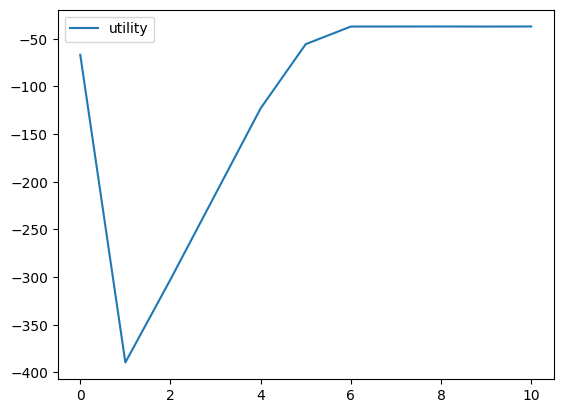

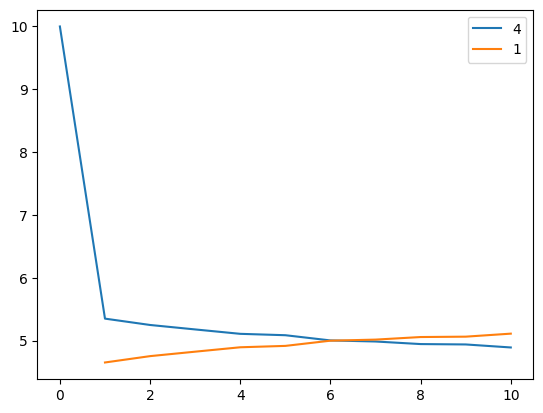

In [181]:
network = nx.DiGraph([(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)])

node_positions = {
    0: np.array([0, 1]),
    1: np.array([0.5, 1]),
    2: np.array([1, 1]),
    3: np.array([0, 0]),
    4: np.array([0.5, 0]),
    5: np.array([1, 0])
}

nx.set_node_attributes(network, node_positions, 'position')

# Latency is defined in terms of the load, i.e., the number of cars on the road
latency_fns = {
    (0, 1): lambda n: 3 + 3 * n,
    (0, 3): lambda n: 0,
    (1, 2): lambda n: 3 + 3 * n,
    (2, 5): lambda n: 0,
    (3, 4): lambda n: 3 + 3 * n,
    (4, 5): lambda n: 3 + 3 * n,
}

nx.set_edge_attributes(network, latency_fns, 'latency_fn')

number_of_cars = 10
cars = [Car(0, 5, np.array([0.5, 0.6]), alpha=1) for _ in range(number_of_cars)] # Parking spaces at node 1 are slightly more attractive

model = ParkingModel(network, parking_spaces, cars)

utility, utilization = [], []
for i in trange(11):
    model.parking_spaces = [ParkingSpace(1, np.array([0.5, 0.8])) for _ in range(i)] + [ParkingSpace(4, np.array([0.5, 0.2])) for _ in range(10)]
    nx.set_node_attributes(network, {node: [parking_space for parking_space in model.parking_spaces if parking_space.node == node] for node in network.nodes}, 'parking_spaces')

    update_flow(network, {edge: 0 for edge in network.edges})

    results, utility_results = run(model, 1000)

    utility.append({'utility': utility_results.mean().mean()})
    utilization.append(pd.DataFrame(results.apply(lambda row: pd.Series(Counter(row)), axis=1)).mean().to_dict())

utility = pd.DataFrame(utility)
utility.plot()

utilization = pd.DataFrame(utilization)
utilization.plot()

In [193]:
v = np.array([2, 4, 6])
softmax(v / np.linalg.norm(v))

array([0.24918921, 0.32553622, 0.42527456])

# Macro model

In [289]:
class Car:
    def __init__(self, entry, exit, target, beta=2.0) -> None:
        self.entry = entry
        self.exit = exit
        self.target = target

        self.beta = beta # Relative disutility of walking
        self.minimum_utility = -100

        self.current_parking_lot = None
        self.current_route = None

    def utility(self, network, parking_lot):
        parking_probability = min(1.0, network.nodes[parking_lot]['capacity'] / (network.nodes[parking_lot]['utilization'] + 1))
        parking_utility = -nx.shortest_path_length(network, self.entry, parking_lot, weight='latency') - self.beta * np.linalg.norm(self.target - network.nodes[parking_lot]['position'])

        # print(f'{parking_probability=}, {parking_utility=}')

        return parking_probability * parking_utility + (1 - parking_probability) * self.minimum_utility

    def route(self, network, parking_lot):
        return nx.shortest_path(model.network, car.entry, parking_lot, weight='latency') + nx.shortest_path(model.network, parking_lot, car.exit, weight='latency')[1:]
            
    def __repr__(self) -> str:
        return f'<Car {self.entry} -> {self.target} -> {self.exit}'

class ParkingModel:
    def __init__(self, network, cars) -> None:
        self.network = network
        self.cars = cars

In [290]:
def random_argmax(d):
    max_value = max(d.values())
    return np.random.choice([k for k, v in d.items() if v == max_value])

In [393]:
network = nx.DiGraph([(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)])

node_positions = {
    0: np.array([0, 1]),
    1: np.array([0.5, 1]),
    2: np.array([1, 1]),
    3: np.array([0, 0]),
    4: np.array([0.5, 0]),
    5: np.array([1, 0])
}

nx.set_node_attributes(network, node_positions, 'position')

# Latency is defined in terms of the load, i.e., the number of cars on the road
latency_fns = {
    (0, 1): lambda n: 3 + 3 * n,
    (0, 3): lambda n: 0,
    (1, 2): lambda n: 3 + 3 * n,
    (2, 5): lambda n: 0,
    (3, 4): lambda n: 3 + 3 * n,
    (4, 5): lambda n: 3 + 3 * n,
}

nx.set_edge_attributes(network, latency_fns, 'latency_fn')

nx.set_node_attributes(network, 0, 'utilization')

capacities = {
    0: 0,
    1: 10,
    2: 0,
    3: 0,
    4: 10,
    5: 0
}

nx.set_node_attributes(network, capacities, 'capacity')

nx.set_node_attributes(network, 0, 'utilization')

number_of_cars = 10
cars = {i: Car(0, 5, np.array([0.5, 0.6])) for i in range(number_of_cars)} # Parking spaces at node 1 are slightly more attractive

model = ParkingModel(network, cars)

In [394]:
def run(model, number_of_steps, init=True, real_time_traffic=False, real_time_utilization=True):
    if init:
        nx.set_edge_attributes(network, 0, 'utilization')
        nx.set_edge_attributes(network, {(v, w): attr['latency_fn'](attr['utilization']) for v, w, attr in network.edges(data=True)}, 'latency')
        nx.set_node_attributes(network, 0, 'utilization')

        for car in model.cars.values():
            car.state = None

    results = []
    for step in range(number_of_steps):

        if not real_time_traffic:
            nx.set_edge_attributes(network, 0, 'utilization')
            nx.set_edge_attributes(network, {(v, w): attr['latency_fn'](attr['utilization']) for v, w, attr in network.edges(data=True)}, 'latency')

        if not real_time_utilization:
            nx.set_node_attributes(network, 0, 'utilization')

        for id in np.random.permutation(len(cars)):
            car = cars[id]

            utilities_ = {node: car.utility(model.network, node) for node in model.network.nodes}
            car.current_parking_lot = random_argmax(utilities_)
            car.current_route = car.route(network, car.current_parking_lot)

            if real_time_utilization:
                parking_lot_utilization = Counter(car_.current_parking_lot for car_ in model.cars.values() if car_.current_parking_lot if not None)
                nx.set_node_attributes(network, parking_lot_utilization, 'utilization')

            if real_time_traffic:
                road_utilization = Counter(sum((tuple(zip(car_.current_route, car_.current_route[1:])) for car_ in model.cars.values() if car_.current_route is not None), start=()))
                nx.set_edge_attributes(network, road_utilization, 'utilization')
                nx.set_edge_attributes(network, {(v, w): attr['latency_fn'](attr['utilization']) for v, w, attr in network.edges(data=True)}, 'latency')

        if not real_time_traffic:
            road_utilization = Counter(sum((tuple(zip(car_.current_route, car_.current_route[1:])) for car_ in model.cars.values() if car_.current_route is not None), start=()))
            nx.set_edge_attributes(network, road_utilization, 'utilization')
            nx.set_edge_attributes(network, {(v, w): attr['latency_fn'](attr['utilization']) for v, w, attr in network.edges(data=True)}, 'latency')

        if not real_time_utilization:
            parking_lot_utilization = Counter(car_.current_parking_lot for car_ in model.cars.values() if car_.current_parking_lot if not None)
            nx.set_node_attributes(network, parking_lot_utilization, 'utilization')

        results.append({'utilities': {id: car.utility(model.network, car.current_parking_lot) for id, car in model.cars.items()}, 'parking_lot_utilization': nx.get_node_attributes(network, 'utilization')})
    
    return pd.DataFrame(results)

100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


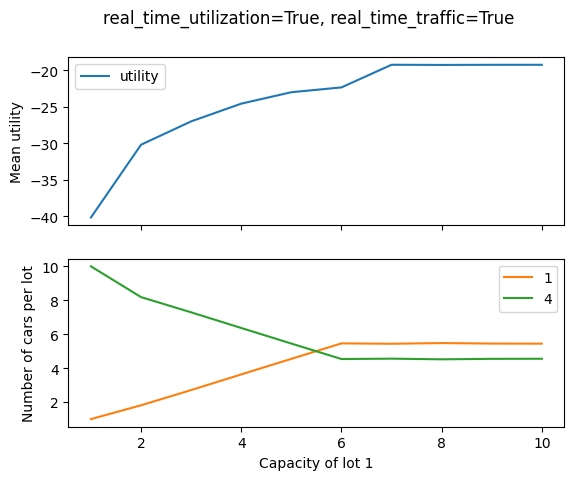

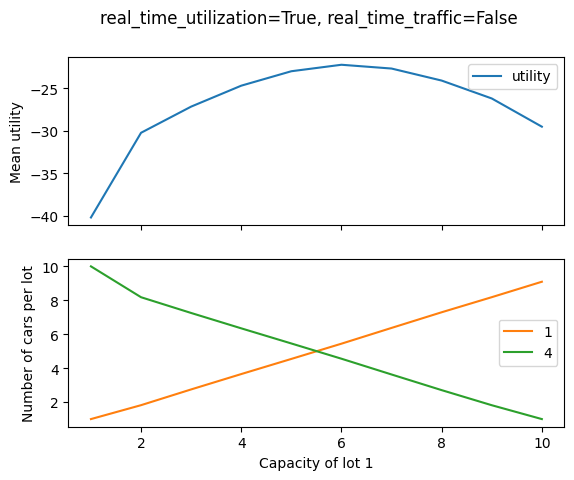

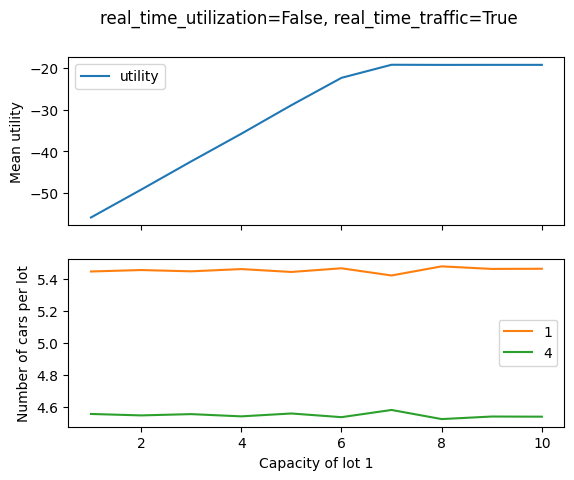

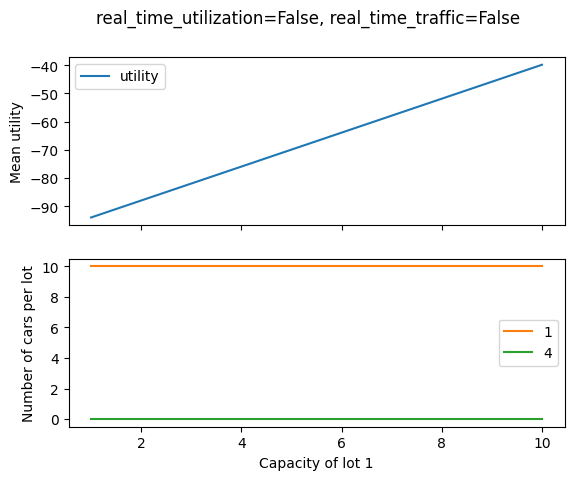

In [398]:
model = ParkingModel(network, cars)
number_of_steps = 1_000

for real_time_utilization, real_time_traffic in itertools.product([True, False], repeat=2):
    r = []
    for capacity in trange(1, 11):
        model.network.nodes[1]['capacity'] = capacity

        results = run(model, number_of_steps=number_of_steps, real_time_utilization=real_time_utilization, real_time_traffic=real_time_traffic)

        r.append({'capacity': capacity, 'utility': results['utilities'].apply(pd.Series).mean().mean(), **results['parking_lot_utilization'].apply(pd.Series)[[1, 4]].mean().to_dict()})

    r = pd.DataFrame(r).set_index('capacity')
    axes = r.plot(xlabel='Capacity of lot 1', title=f'{real_time_utilization=}, {real_time_traffic=}', subplots=[('utility', ), (1, 4)])
    axes[0].set_ylabel('Mean utility')
    axes[1].set_ylabel('Number of cars per lot')